<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [2]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [5]:
data = pd.read_csv('./train.csv')

In [6]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Сперва считаем пустые ячейки (np.nan)

In [7]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Проверим, соответствуют ли типы данных в столбцах ожидаемым:

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

3-й столбец 'Total_spent' вопреки ожиданиям имеет Dtype object, вместо float64. Попробуем заменить возможные пробелы на np.nan и снова посчитать их

In [9]:
for i in num_cols:
    data[i] = pd.to_numeric(data[i], errors='coerce')
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Видим, что 9 значений в столбце сменились на np.nan. Далее либо удаляем строки с 'нанами', или заменим отсутствующие значения на что либо. Глянем что из себя представляют данные в первых трёх столбцах

In [10]:
data[num_cols]

,ClientPeriod,MonthlySpending,TotalSpent
0,55,19.50,1026.35
1,72,25.85,1872.20
2,1,75.90,75.90
3,32,79.30,2570.00
4,60,115.25,6758.45
...,...,...,...
5277,3,30.40,82.15
5278,50,44.45,2188.45
5279,1,55.05,55.05
5280,29,76.00,2215.25


Не сложно заметить, что TotalSpent это произведение ClientPeriod и MonthlySpending. Заменим недостающие значения на произведение первых двух столбцов

In [11]:
multi_col = data[num_cols[0]] * data[num_cols[1]]
data[num_cols[2]] = data[num_cols[2]].fillna(multi_col)

Проверим np.nan после обработки

In [12]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Пустых ячеек не осталось - двигаемся дальше


## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

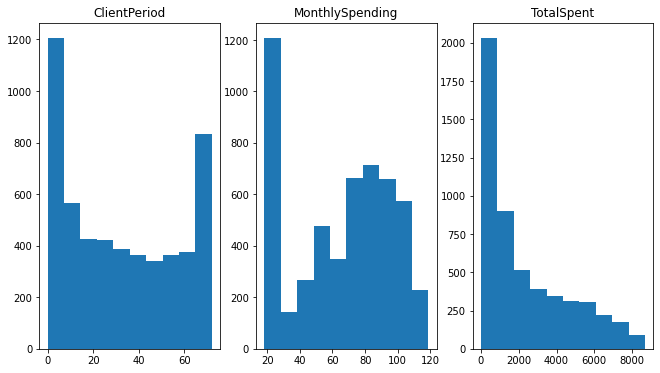

In [167]:
fig, ax = plt.subplots(1, 3,figsize=(11, 6), sharex=False, sharey=False)
for i, v in enumerate(num_cols):
    ax[i].hist(data[v])
    ax[i].set_title(v)
plt.show()

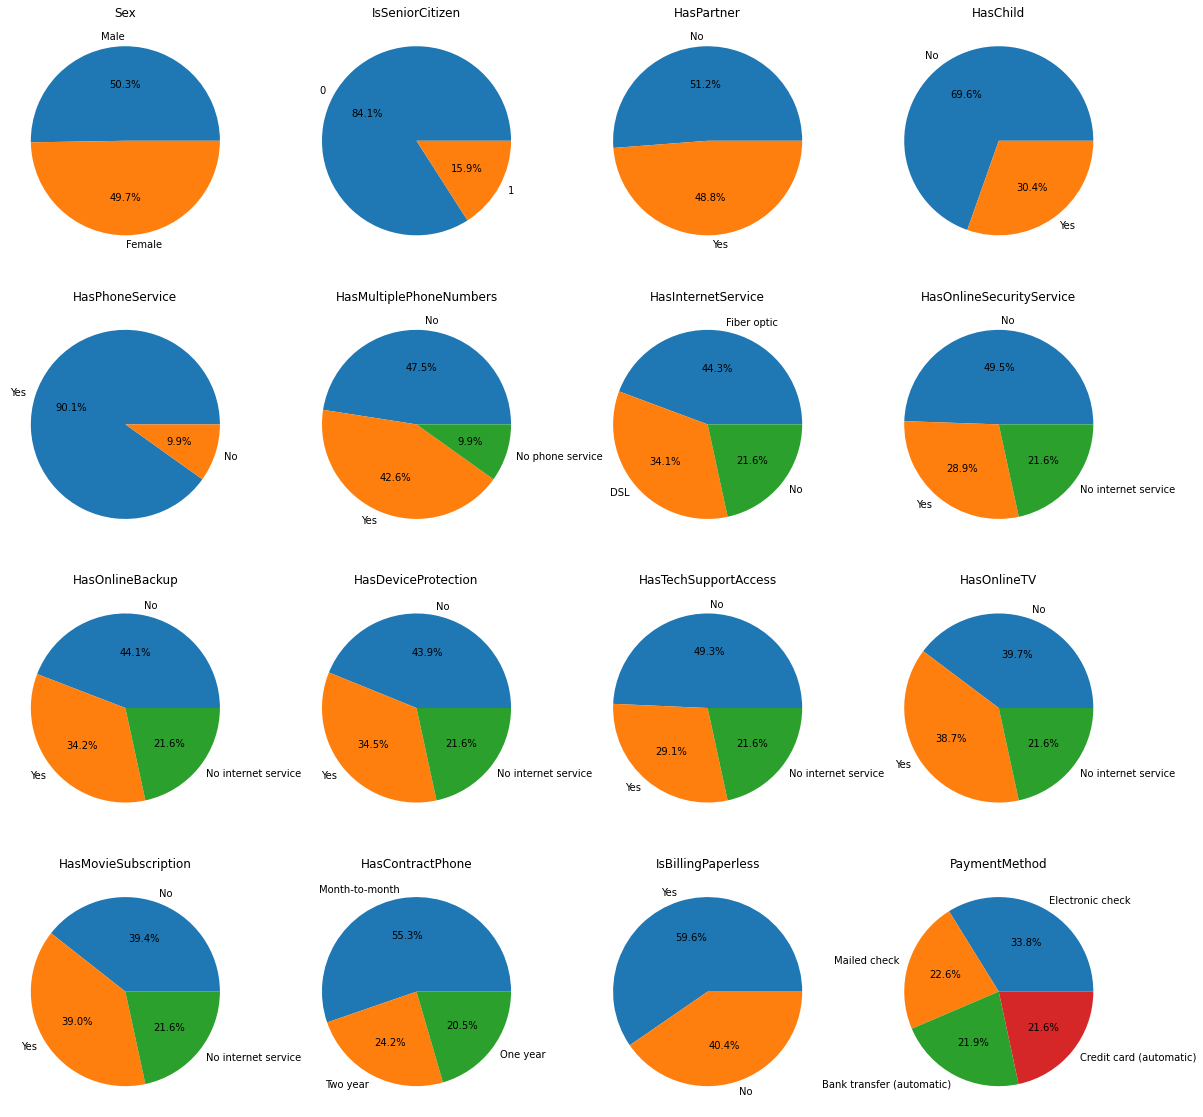

In [168]:
rows = 4
cols = 4
fig, ax = plt.subplots(rows, cols,figsize=(20,20), sharex=True, sharey=True)
iteration = 0
for i in range(0, rows):
    for j in range(0, cols):
        temp_data = data[cat_cols[iteration]].value_counts()
        ax[i][j].pie(temp_data, labels = temp_data.index, autopct='%1.1f%%')
        ax[i][j].set_title(cat_cols[iteration])
        iteration += 1
plt.show()

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [13]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [14]:
scaller = StandardScaler()
data_1 = data.copy()
data_1[num_cols] = scaller.fit_transform(data_1[num_cols])
data_1 = pd.get_dummies(data_1, columns=cat_cols)

In [15]:
feature_data_1 = data_1.drop('Churn', 1)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(feature_data_1, data_1[target_col])

In [16]:
lrcv = LogisticRegressionCV()
lrcv.fit(X_train_1, y_train_1)
predict = lrcv.predict_proba(X_test_1)[:,1]
roc_auc_score(y_test_1, predict)

0.8362772866420621

Попробуем другую регрессионную модель. Для начала проведём поиск лучшего гипперпараметра

In [17]:
grid_search = GridSearchCV(LogisticRegression(max_iter=500), {'C' : [i for i in range(0, 11, 1)]}, cv=5, scoring='roc_auc',verbose=True)
grid_search.fit(X_train_1, y_train_1)


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFaile

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=True)

In [18]:
grid_search.best_params_

{'C': 9}

Затем используем найденный параметр в обучении модели

In [22]:
lr = LogisticRegression(C=6, max_iter=500)

lr.fit(X_train_1, y_train_1)
pr1 = lr.predict_proba(X_test_1)[:,1]
roc_auc_score(y_test_1, pr1)


0.8361456813435184

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [23]:
lrcv.get_params(deep=True)

{'Cs': 10,
 'class_weight': None,
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [24]:
print('LogisticRegression(C=):', roc_auc_score(y_test_1, pr1),'\n', 'LogisticRegressionCV:', roc_auc_score(y_test_1, predict))

LogisticRegression(C=): 0.8361456813435184 
 LogisticRegressionCV: 0.8362772866420621


## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [25]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 24 kB/s 


In [26]:
import catboost 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_cols], data[target_col])

In [31]:
cb = catboost.CatBoostClassifier(n_estimators=500, cat_features=cat_cols, verbose=False, learning_rate=0.05)
cb.fit(X_train, y_train, eval_set=(X_test, y_test))
cb_pred = cb.predict_proba(X_test)[:,1]
roc_auc_score(y_test, cb_pred)

0.8495792507874519

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [32]:
cb.get_params(deep=True), roc_auc_score(y_test, cb_pred)

({'cat_features': ['Sex',
   'IsSeniorCitizen',
   'HasPartner',
   'HasChild',
   'HasPhoneService',
   'HasMultiplePhoneNumbers',
   'HasInternetService',
   'HasOnlineSecurityService',
   'HasOnlineBackup',
   'HasDeviceProtection',
   'HasTechSupportAccess',
   'HasOnlineTV',
   'HasMovieSubscription',
   'HasContractPhone',
   'IsBillingPaperless',
   'PaymentMethod'],
  'learning_rate': 0.05,
  'n_estimators': 500,
  'verbose': False},
 0.8495792507874519)

Взглянем на результаты работы трёх моделей:

In [34]:
print('CatBoost:', roc_auc_score(y_test, cb_pred),'\n', 'LogisticRegression(C=):', roc_auc_score(y_test_1, pr1),'\n', 'LogisticRegressionCV:', roc_auc_score(y_test_1, predict))

CatBoost: 0.8495792507874519 
 LogisticRegression(C=): 0.8361456813435184 
 LogisticRegressionCV: 0.8362772866420621


# Предсказания

In [35]:
best_model = cb

In [36]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')


Проведём подготовку тестового датафрейма. Проверим наличие пустых ячеек и заменим их произведением первых двух колонок, как и в тренировочном сете

In [37]:
for i in num_cols:
    X_test[i] = pd.to_numeric(X_test[i], errors='coerce')

In [38]:
multi_col = data[num_cols[0]] * data[num_cols[1]]
data[num_cols[2]] = data[num_cols[2]].fillna(multi_col)

In [39]:
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

In [60]:
submission = pd.read_csv('./submission.csv')

submission['Churn'] = cb.predict_proba(X_test)[:,-1]
submission.to_csv('./my_submission.csv', index=False)
submission


,Id,Churn
0,0,0.033064
1,1,0.699095
2,2,0.640516
3,3,0.009944
4,4,0.008542
...,...,...
1756,1756,0.122793
1757,1757,0.008748
1758,1758,0.854373
1759,1759,0.609529


In [61]:
my_sub = pd.read_csv('./my_submission.csv')
my_sub

,Id,Churn
0,0,0.033064
1,1,0.699095
2,2,0.640516
3,3,0.009944
4,4,0.008542
...,...,...
1756,1756,0.122793
1757,1757,0.008748
1758,1758,0.854373
1759,1759,0.609529


# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.